# Practical Exam Submission

Business :
Recipe website looking to improve traffic by selecting different recipes to display on the front page.

Goals : 
- Which recipes will lead to high traffic?
- Can we correctly predict high traffic recipes 80% of the time?

# Data Validation

## Load libraries and data set

We found NaNs present in five columns, which we will deal with by simply dropping any row with NaNs.

The 'servings' column was in str format, and contained 'as a snack' in a number of entries.

The 'category' column showed an extra 'Chicken' category which needed to be fixed.

The 'high_traffic' column has only 'High' and NaN entries. We must assume the NaNs are the 'Low' traffic recipes.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


col_names = ['recipe', 'calories', 'carbohydrate', 
             'sugar', 'protein', 'category', 'servings', 
             'high_traffic']
nut_cols = ['calories', 'carbohydrate', 
             'sugar', 'protein']

numeric_cols = ['recipe', 'calories', 'carbohydrate', 
                'sugar', 'protein', 'servings']

categorical_cols = ['category']


In [2]:

# Load data
df= pd.read_csv('recipe_site_traffic_2212.csv', sep=',')
df['high_traffic'] = df['high_traffic'].fillna('Low')

# NaN check
# print(df.isna().any())
df = df.dropna(axis=0)

# Check numeric datatypes
# print(df[numeric_cols].dtypes)
df['servings'] = df['servings'].str.replace(' as a snack','').astype(int)

# Turn the categorical column into categorical data type
# print(df['category'].unique())
df['category'] = np.where(
    df['category']=='Chicken Breast',
    'Chicken',
    df['category']
)
df['category'] = pd.Categorical(
    df['category'], 
    categories=['Lunch/Snacks', 'Beverages',
                'Potato','Vegetable', 'Meat',
                'Chicken','Pork','Dessert',
                'Breakfast','One Dish Meal'
                ]
)



# EDA


There are some data points suggestive of being outliers, which are candidates for removing to improve model training.

There appears to be more high traffic recipes than not, and the distributions of nutritional content values appear similar between the high and low traffic recipes.

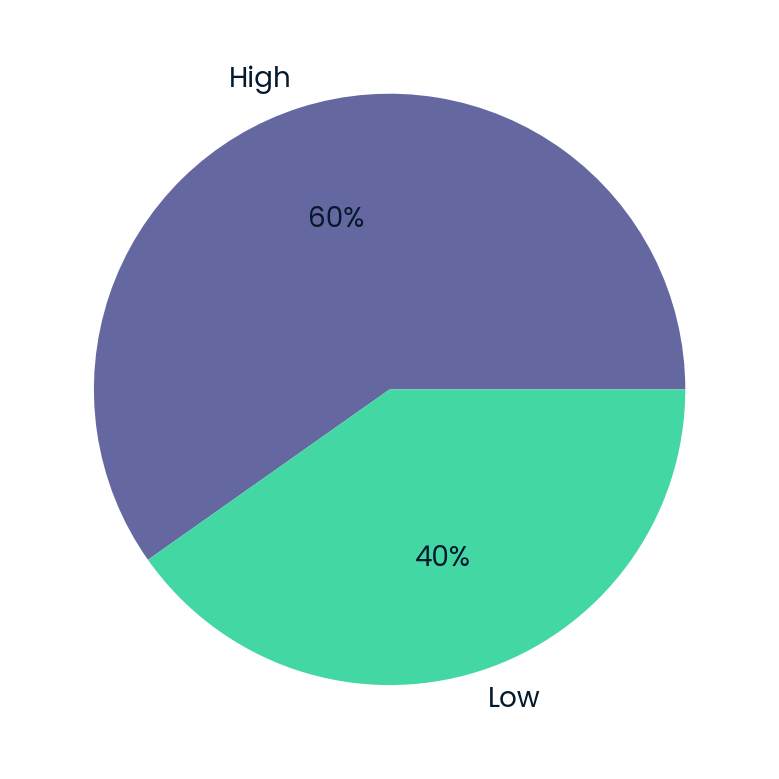

In [3]:
counts = df['high_traffic'].value_counts()

plt.pie(counts.values, labels=counts.index, autopct='%.0f%%')
plt.show()

## Nutritional Info Distributions

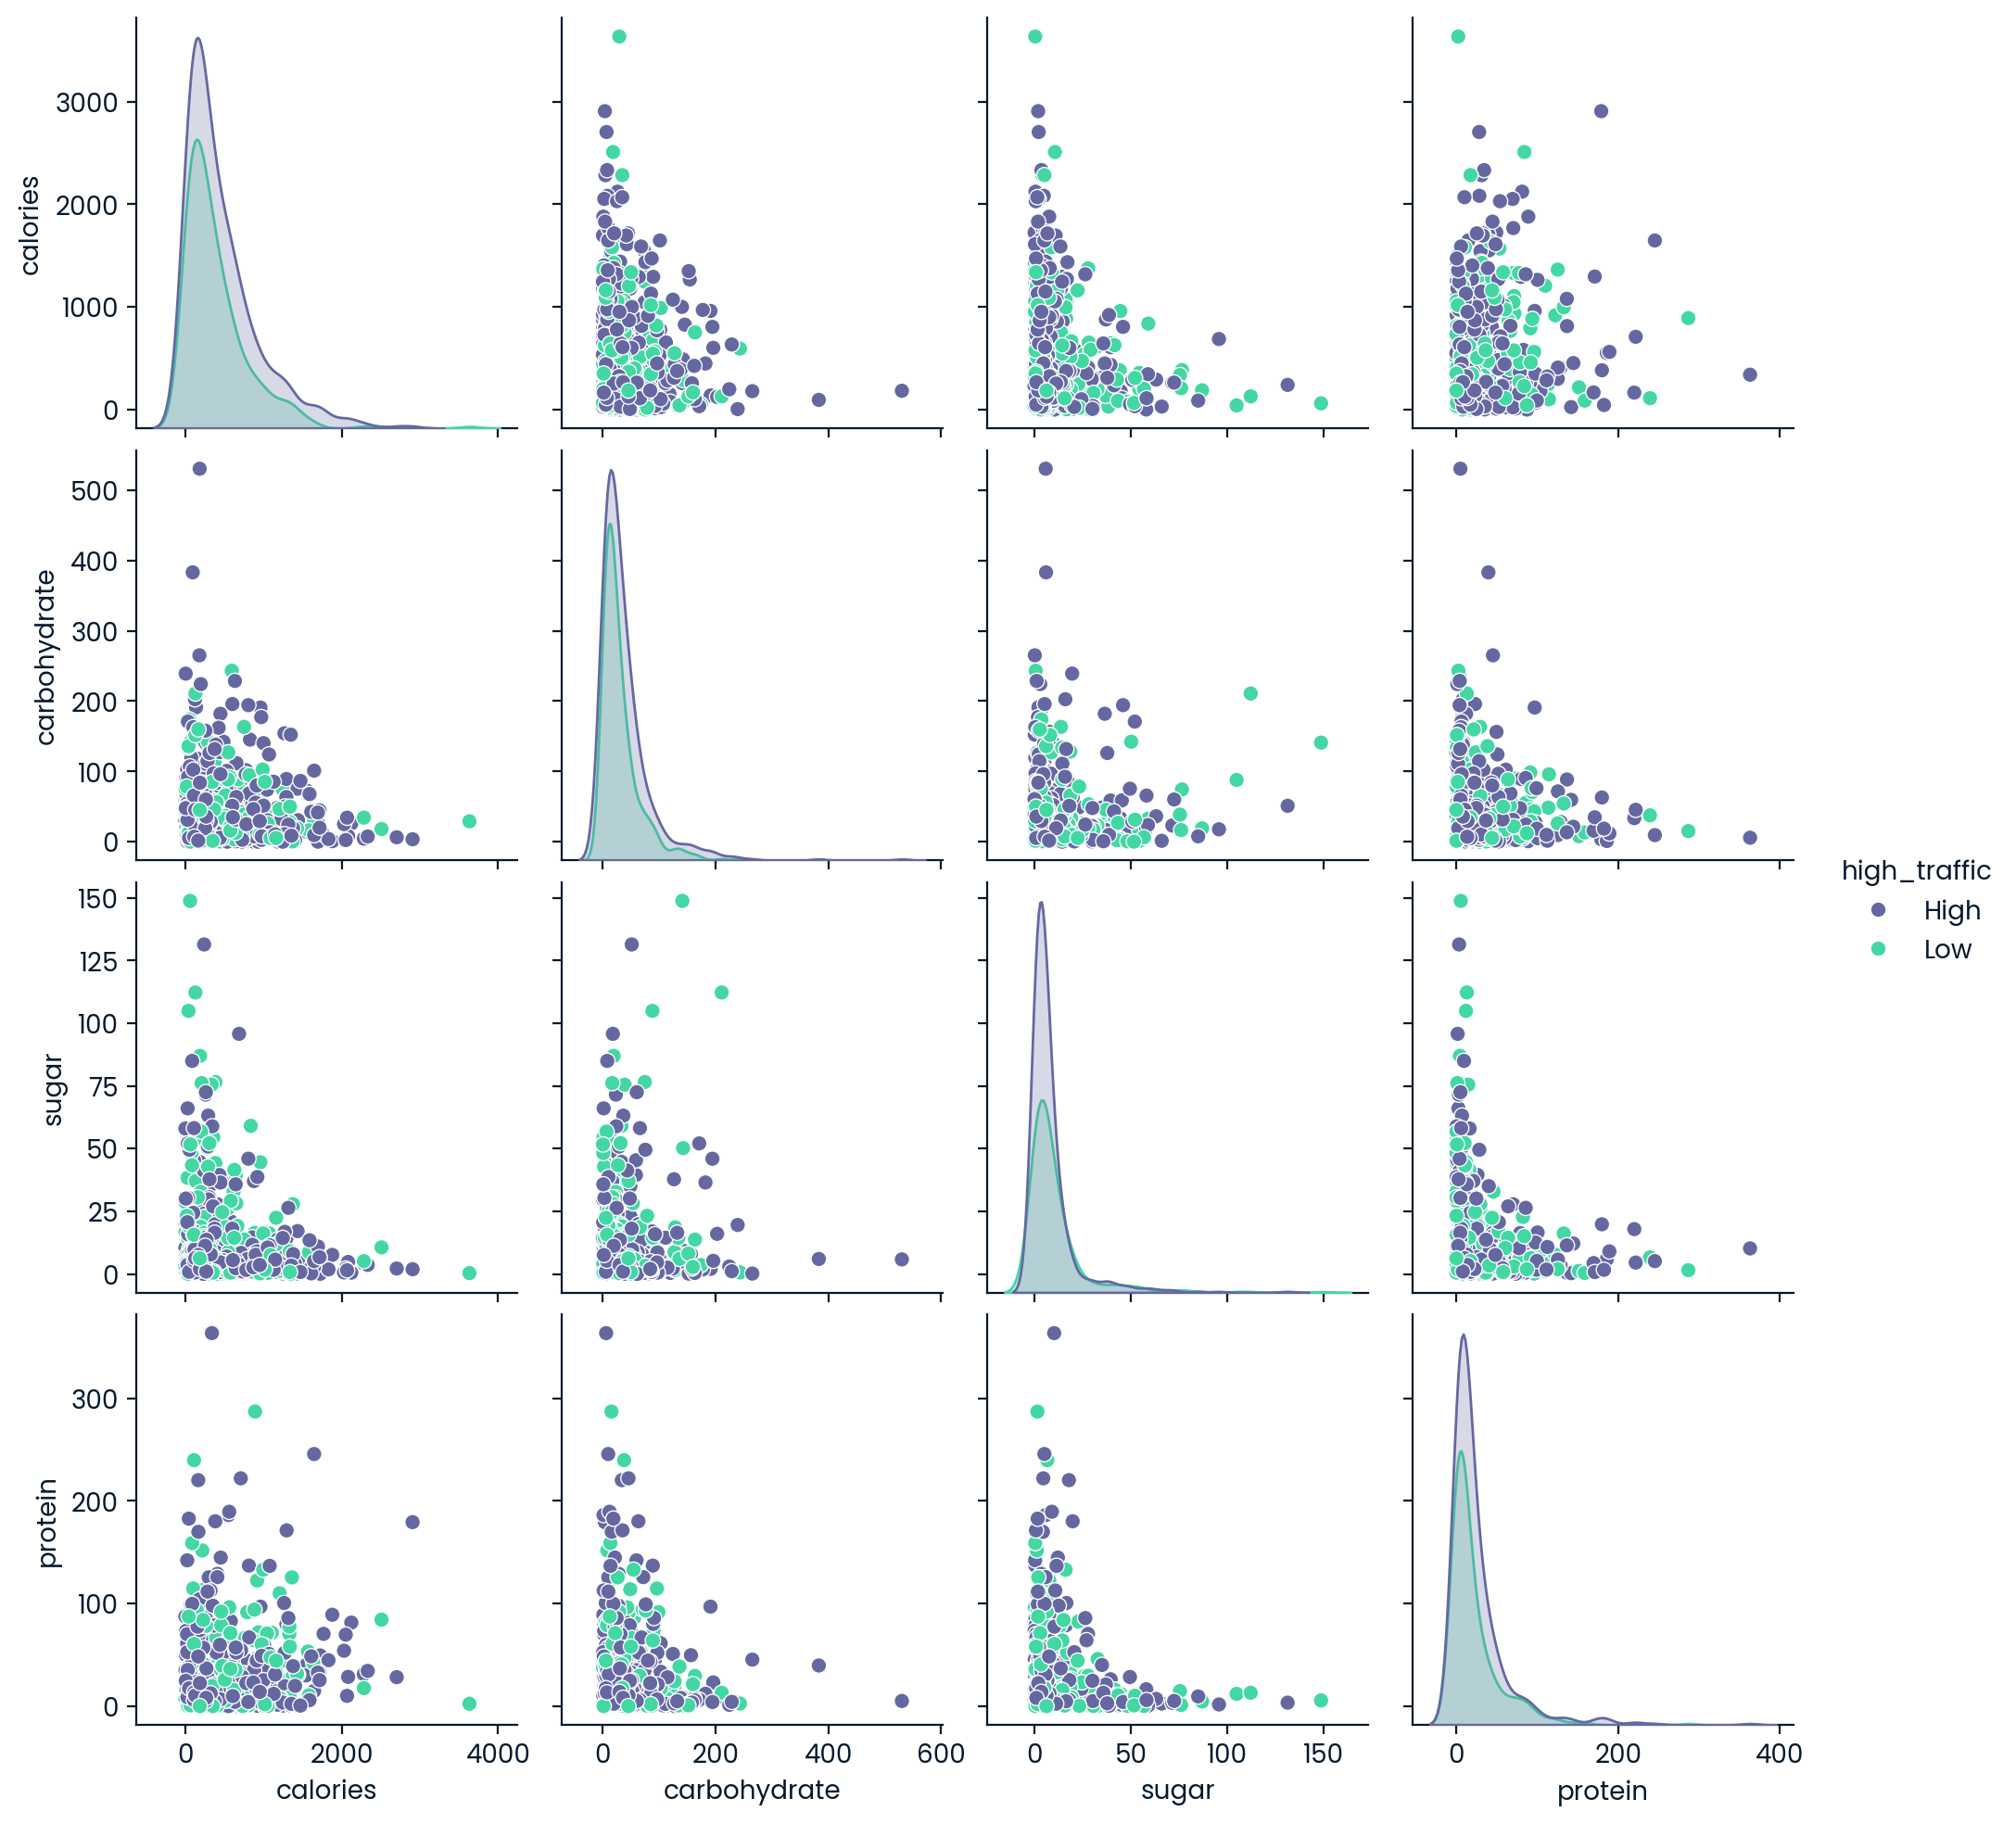

In [4]:
g = sns.pairplot(df.drop(columns=['recipe','servings']), hue='high_traffic')


The data exhibits greater presence of recipes with 4 servings. As well, the numerical data demonstrates a non-Gaussian distribution, and could be exponential or Poissonian. They are all distributed similarly.

<AxesSubplot: xlabel='servings', ylabel='Count'>

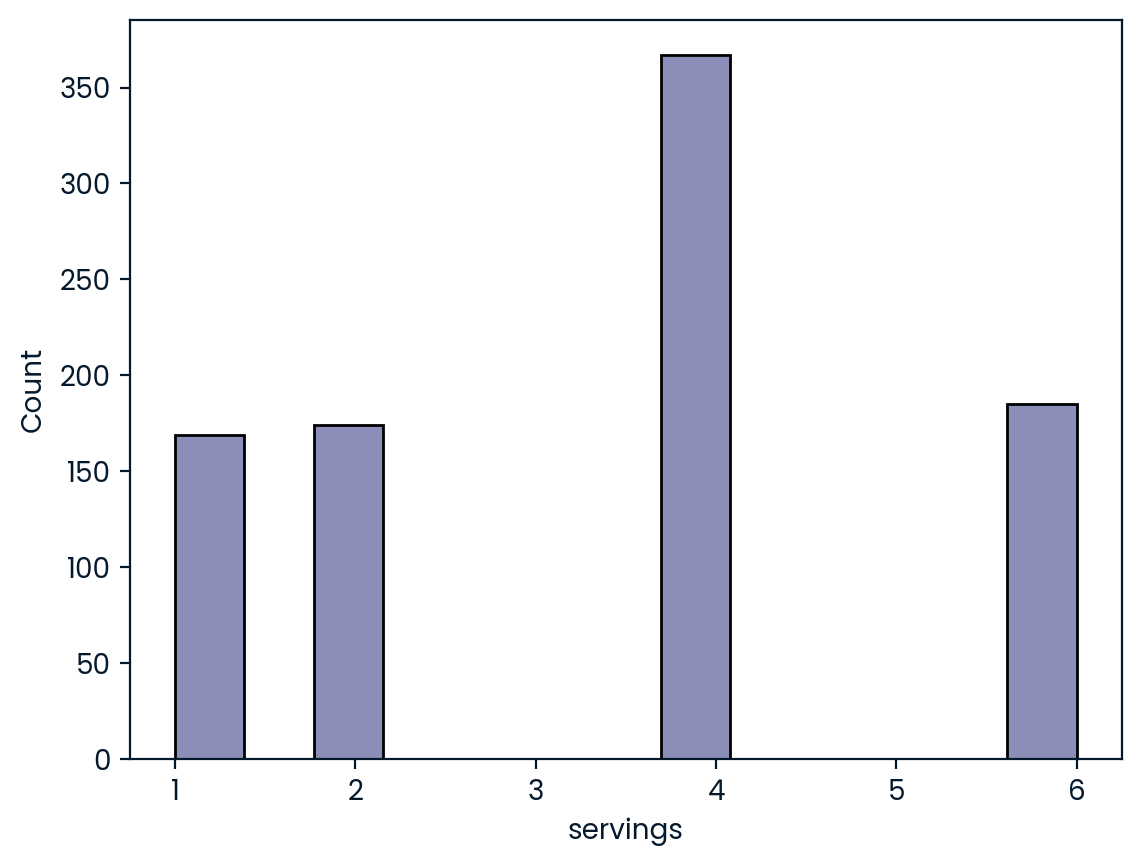

In [5]:
# print(df['servings'].value_counts())
sns.histplot(df['servings'])

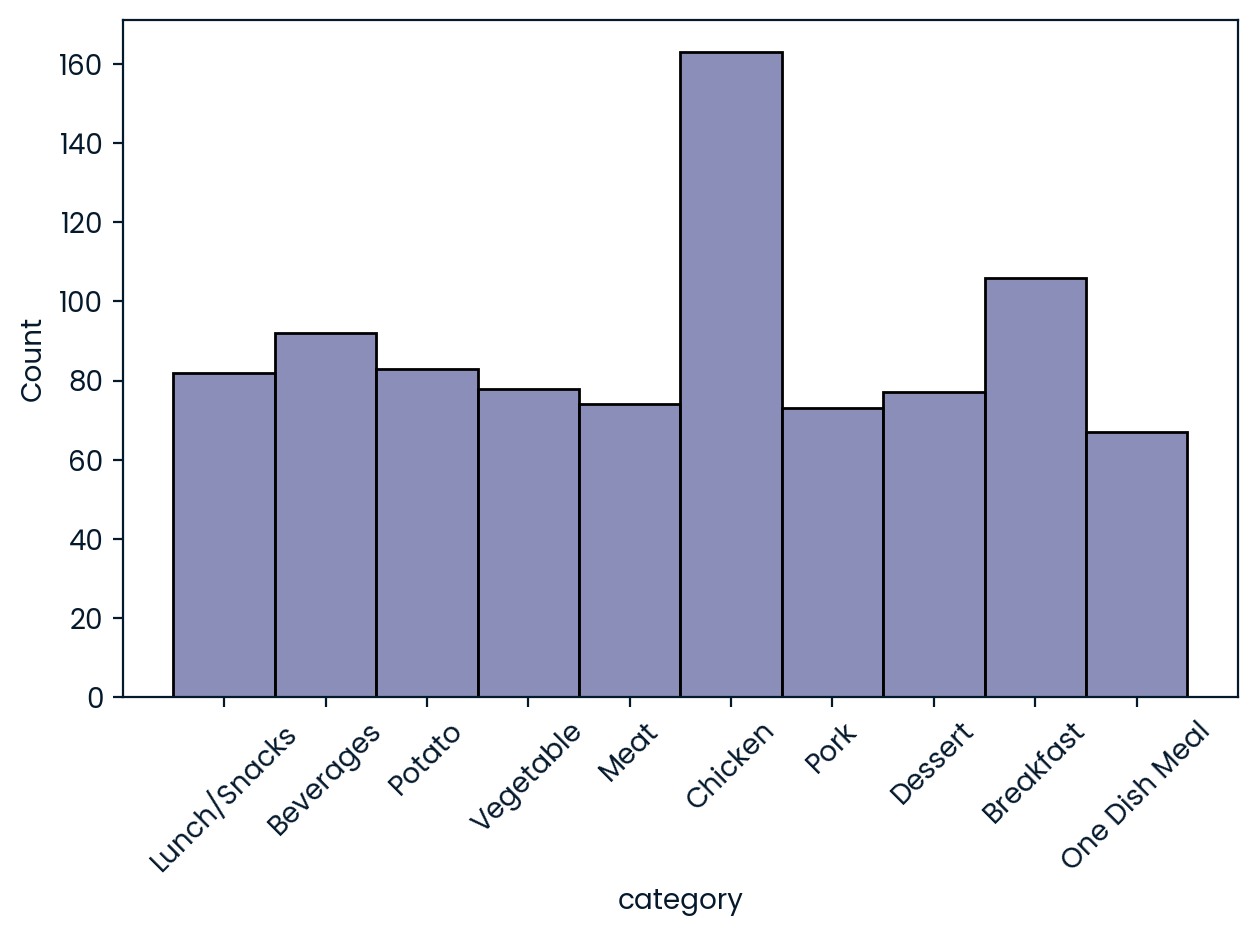

In [6]:
g = sns.histplot(df['category'])
g.tick_params(axis='x',rotation=45)
plt.tight_layout()

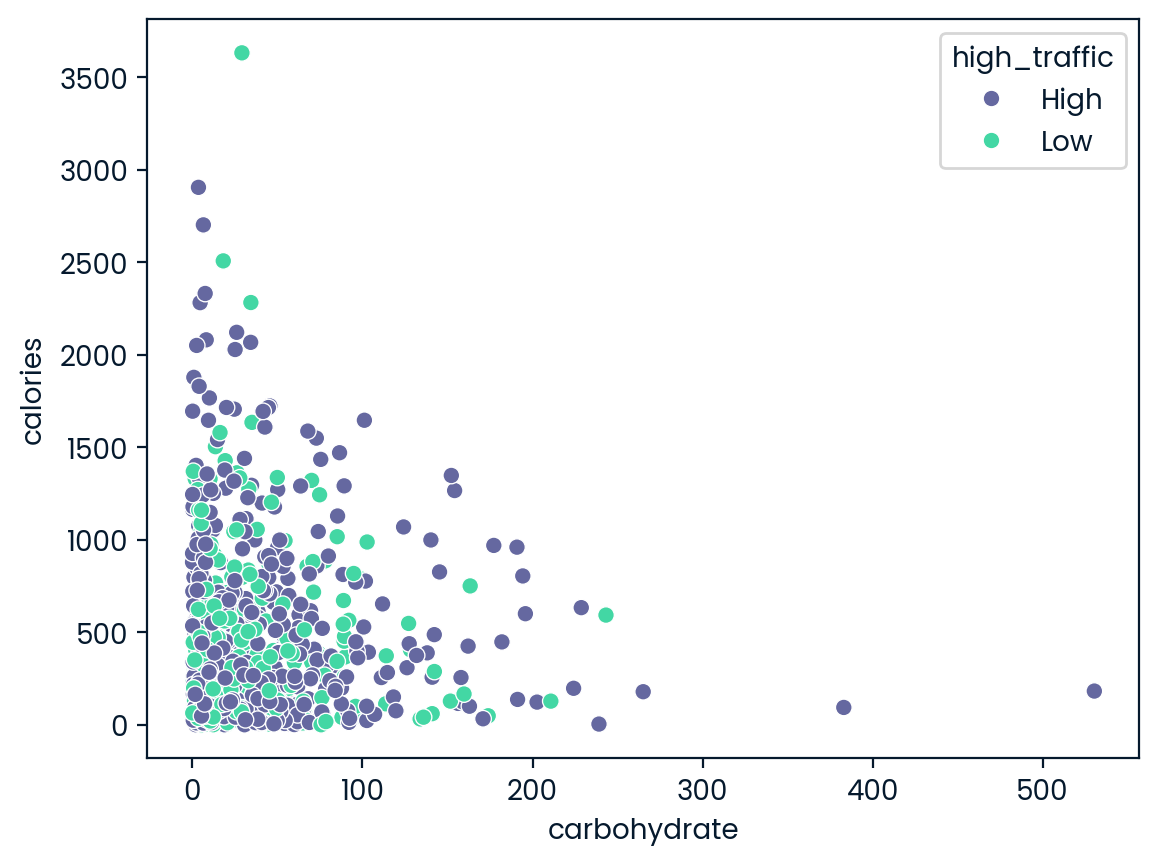

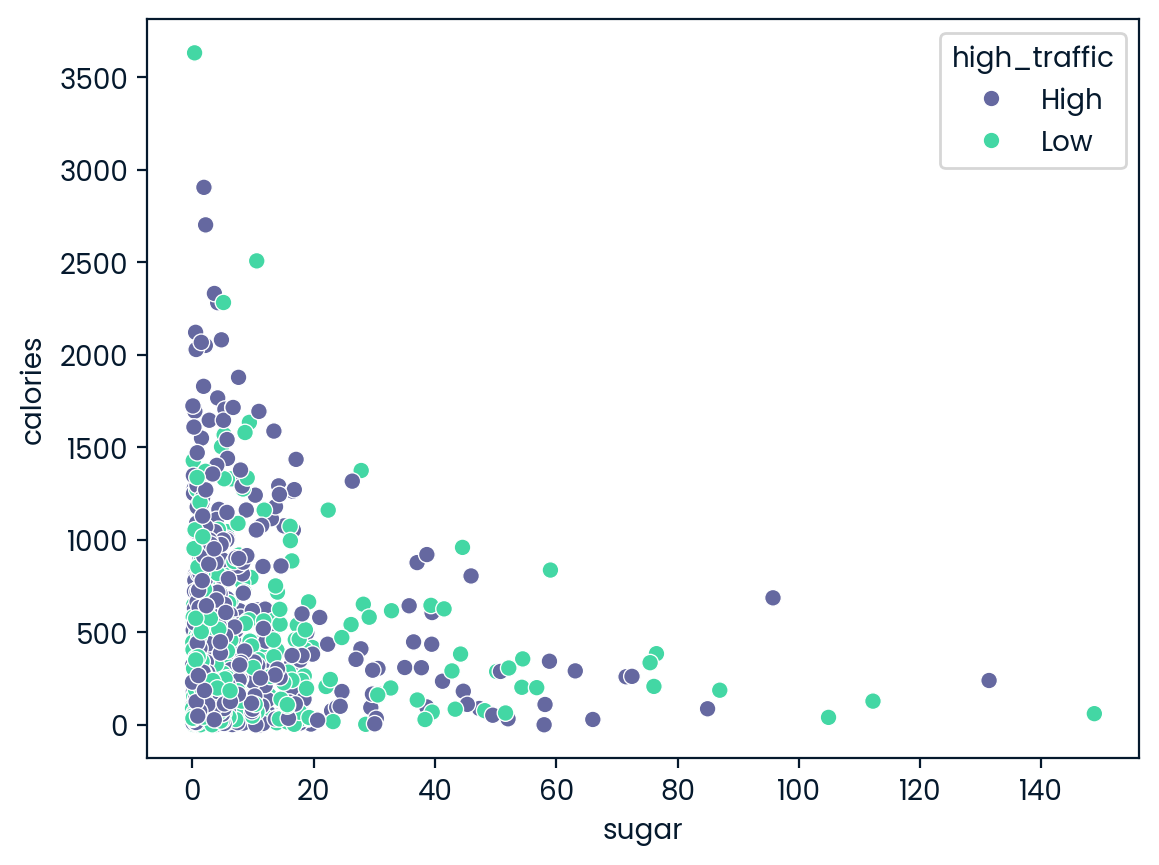

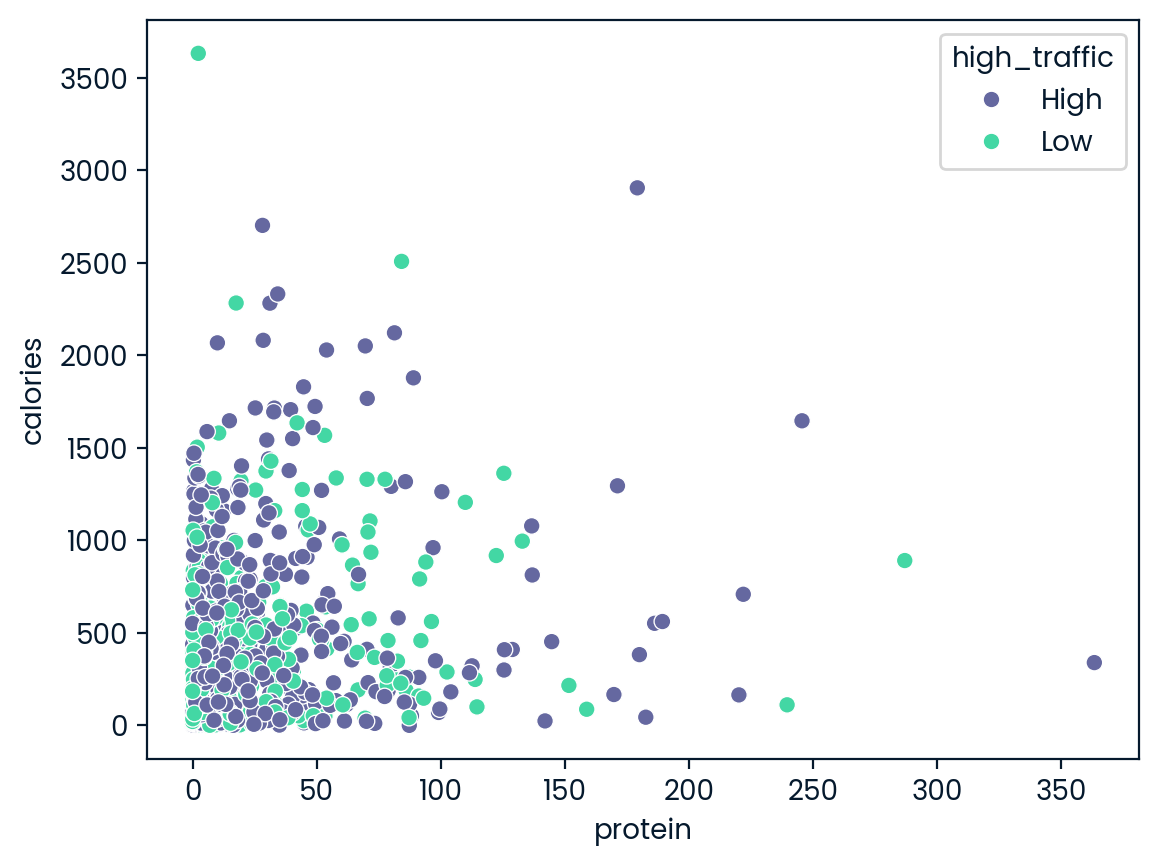

In [7]:
for col in nut_cols:
    if col is not 'calories':
        sns.scatterplot(
            x=col, y='calories',
            data=df, hue='high_traffic'
        )
        plt.show()
    

<AxesSubplot: xlabel='high_traffic', ylabel='protein'>

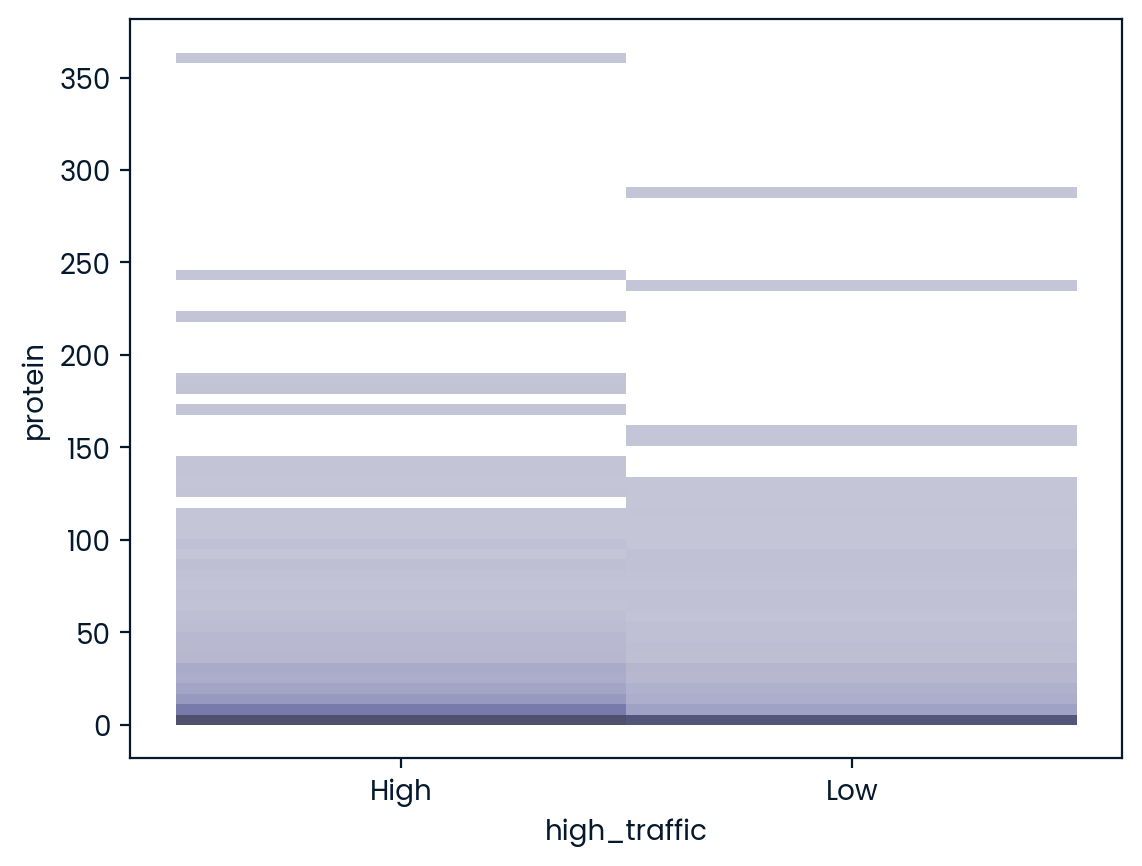

In [8]:
sns.histplot(y='protein', x='high_traffic', data=df)

# Model Fitting

The problem is one of binary classification. Some suitable models for this are LogisticRegression, SVM, KNN, and DecisionTree.

We want to minimize false positives, since putting low traffic recipes in will of course result in lower traffic. Thus, to evaluate the models we will use the 'precision' score, which we want to be 80\%.

In [9]:
# Deal with outliers BEFORE standardscaler is used, will ruin scaling otherwise.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

scaler = MinMaxScaler()  # StandardScaler()


### Massage the Features

In [11]:
model_df = df.copy()
random_state = 77


# Encode categorial data
model_df = pd.get_dummies(model_df, columns=['category'], drop_first=False)
model_df['high_traffic'] = np.where(
    model_df['high_traffic']=='High',
    1, 0
)


feature_cols =  list(model_df.drop(columns=['recipe', 'high_traffic']).columns)
target_col = 'high_traffic'


X = model_df[feature_cols].values
y = model_df[target_col].values



## Model 1: LogisticRegression

Our first attempt uses LogReg, and obtains a precision of 80\%

In [12]:

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Must match supported solvers for each penalty
    'l1_ratio': [0, 0.5, 1]  # Only used when penalty='elasticnet'
}
logreg = LogisticRegression(random_state=random_state)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring= 'precision',  # 'roc_auc',  # neg_root_mean_squared_error',  # mse_scorer, 
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best precision:", grid_search.best_score_)

# Best model (can be used to predict on validation set)
best_logreg = grid_search.best_estimator_
print(np.min(X))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'C': 1, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'liblinear'}
Best precision: 0.8005326812296811
0.0


## Model 2: LinearSVC

Model 2 obtains a precision of 87%, which is an excellent improvement on  LogisticRegssion

In [13]:
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength (inverse)
#     'penalty': ['l1', 'l2'],            # Regularization type
#     'dual': [False, True],              # Depends on penalty and sample size
#     'loss': ['squared_hinge'],          # Default; limited options
# }
param_grid = {
        'penalty': ['l2'],
        'loss': ['squared_hinge'],
        'dual': [True, False],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    }
lsvc = LinearSVC(random_state=random_state)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=lsvc,
    param_grid=param_grid,
    cv=5,
    scoring= 'precision',  # 'roc_auc',  # neg_root_mean_squared_error',  # mse_scorer, 
    error_score='raise',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best Precision:", grid_search.best_score_)

# Best model (can be used to predict on validation set)
best_lsvc = grid_search.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters: {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best Precision: 0.8738012558012558


### Model 3 : KNearestNeighbors

KNN fails to sufficiently predict the target, reaching only 60\% precision.

In [14]:
param_grid = {
    'n_neighbors': np.linspace(1, 100, 10, dtype=int),             # Number of neighbors
    'weights': ['uniform', 'distance'],          # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metrics
    'p': [1, 2]                                   # Minkowski power: 1=manhattan, 2=euclidean
}

knn = KNeighborsClassifier() #random_state=random_state)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring= 'precision',  # 'roc_auc',  # neg_root_mean_squared_error',  # mse_scorer, 
    error_score='raise',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best Precision:", grid_search.best_score_)

# Best model (can be used to predict on validation set)
best_knn = grid_search.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}
Best Precision: 0.6352608599007897


# Business Metrics

To determine the most important features, we extract the absolute valute of the coefficient weights from the best LogisticRegression and best LinearSVC models.

In [15]:

print('Logistic Regression Weights')
for i, coef in enumerate(list(best_logreg.coef_[0])):
    print(feature_cols[i]+': \t\t'+str( np.abs(coef)))

print('\n\nLinearSVC Weights')
for i, coef in enumerate(list(best_lsvc.coef_[0])):
    print(feature_cols[i]+': \t\t'+str( np.abs(coef)))

Logistic Regression Weights
calories: 		3.645654755780665e-05
carbohydrate: 		0.0014527732612754668
sugar: 		0.0061577765348624774
protein: 		0.001374641691522658
servings: 		0.020162898554346994
category_Lunch/Snacks: 		0.1586328538066705
category_Beverages: 		2.9548811568577777
category_Potato: 		1.700113766553249
category_Vegetable: 		2.338791098196446
category_Meat: 		0.3881855241537912
category_Chicken: 		1.0145396823576704
category_Pork: 		1.3347195297546623
category_Dessert: 		0.02163126004866685
category_Breakfast: 		1.4215767748297168
category_One Dish Meal: 		0.3858092715359633


LinearSVC Weights
calories: 		0.003526040919140063
carbohydrate: 		0.003148919324135122
sugar: 		0.007535102674484351
protein: 		0.0051813382364531485
servings: 		0.0013014427069222001
category_Lunch/Snacks: 		0.17871501502636633
category_Beverages: 		0.9842615739204249
category_Potato: 		0.6003903216762373
category_Vegetable: 		0.6409456525292548
category_Meat: 		0.406203591074639
category_Chicken: 

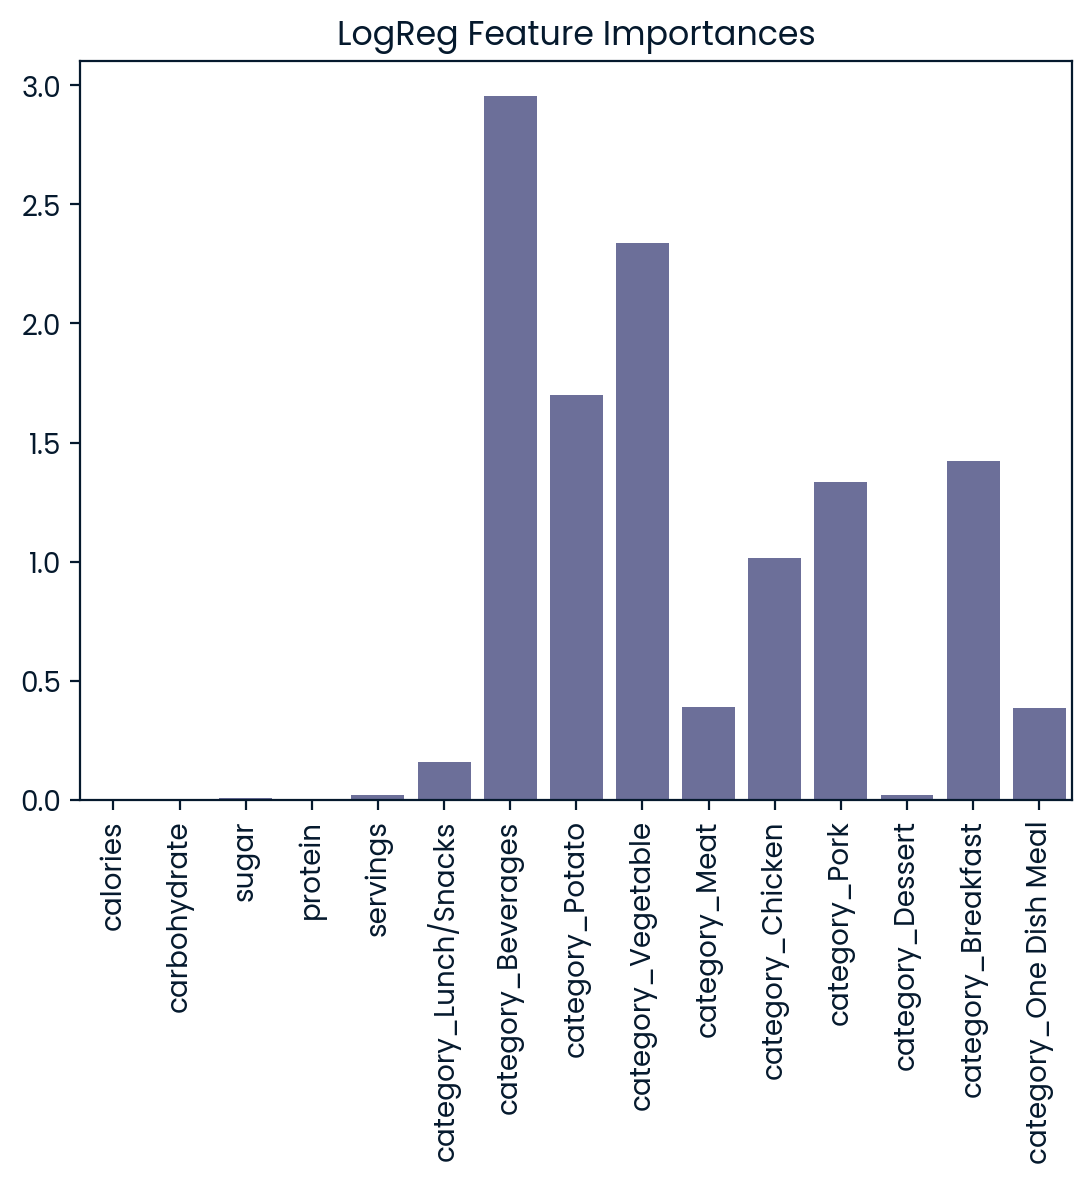

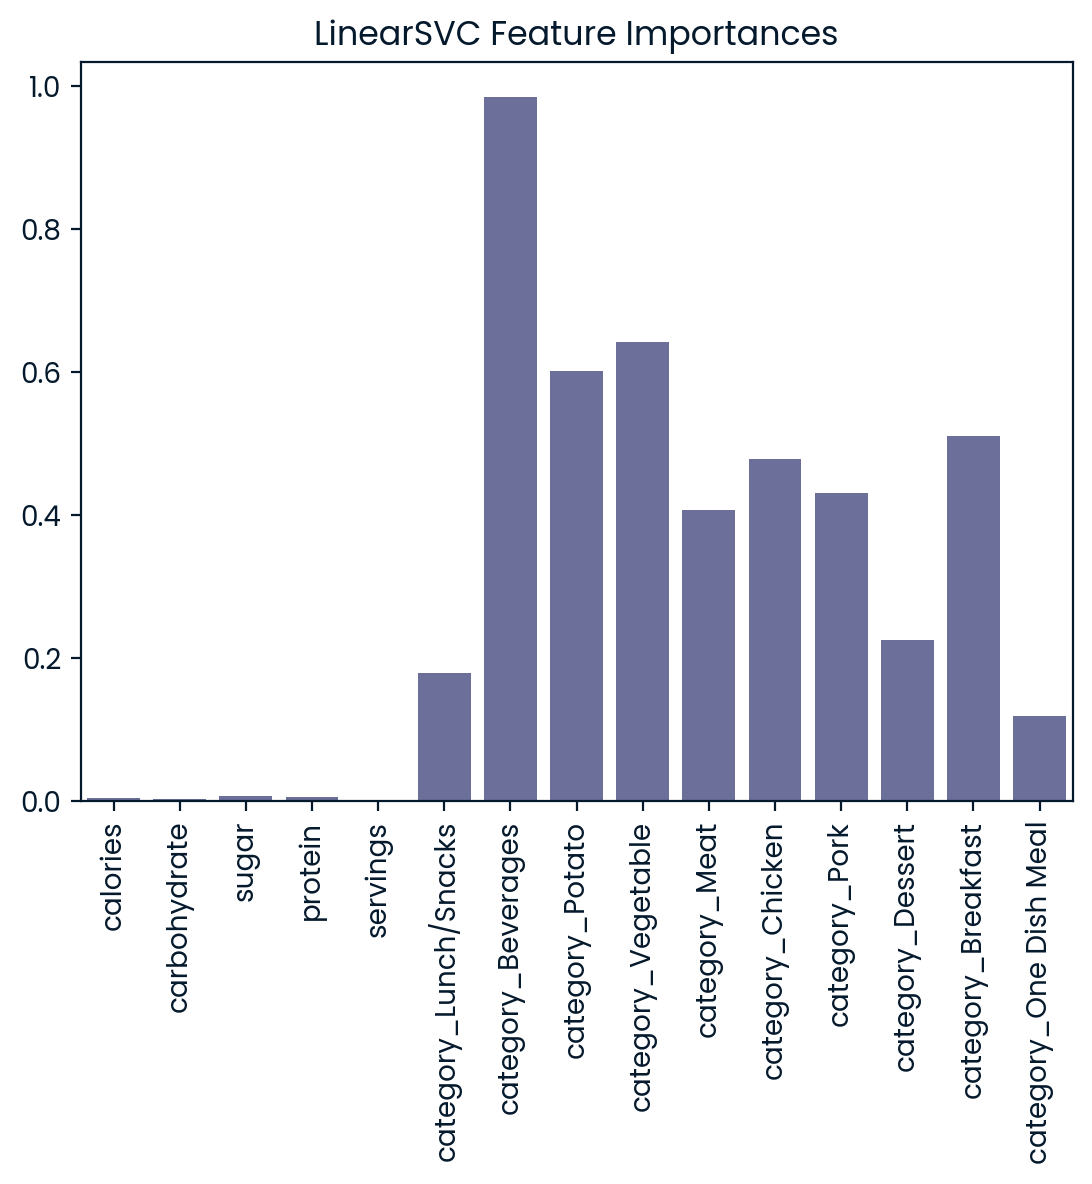

In [16]:
ax = sns.barplot(x=feature_cols, y=list(np.abs(best_logreg.coef_[0])))
ax.tick_params(axis='x',rotation=90)
ax.set_title('LogReg Feature Importances')
plt.show()

ax = sns.barplot(x=feature_cols, y=list(np.abs(best_lsvc.coef_[0])))
ax.tick_params(axis='x',rotation=90)
ax.set_title('LinearSVC Feature Importances')
plt.show()

Both models weight the recipe categories far more strongly than the nutritional information. The top three categories for driving high traffic to the website are Beverages, Vegetable, and Potato. Displaying more of these categories will likely drive more traffic to the website.

# Summary

We were able to successfully predict the high traffic recipes at least 80\% of the time. Our logistic regression model had a precision of 87\%. 

Our models suggest displaying more Beverage, Vegetable, and Potato recipes will increase traffic to the website.

In order to evaluate the efficacy of these recommendations, we suggest tracking the performance of the performance of these recipes as they're posted on the website as a KPI:

$\quad\quad\quad P=\frac{TP}{TP+FP}$

where P is the precision (our KPI), TP are the true positives, and FP are the false positive. Should the success rate of these recipes in driving high traffic drop below 60\% over a statistically significant period of time, the models should be re-trained to account for any shift that may have occured in the demands of the market.